# Description

This notebook will do the final steps for the 95th to 5th percentile ratio results. These include:

1. Create text files (```${RUN}_orig.discard.FV.mean.csv```,```${RUN}_orig.tshift.FV.mean.csv``` and ```${RUN}_orig.detrend.FV.mean.csv```) with mean ventricular time series.
2. Create new version of final FV mask with slice numbers: ```${RUN}_orig.mask.FV.manual.k.nii.gz```
3. Create new version of final FV mask with rank numbers: ```${RUN}_orig.mask.FV.manual.rank.nii.gz```
4. Extract Slice-by-Slice Timeseries for K FV mask: ```${RUN}_orig.discard.FV.k.csv```, ```${RUN}_orig.tshift.FV.k.csv``` and ```${RUN}_orig.detrend.FV.k.csv```
5. Extract Slice-by-Slice Timeseries for rank FV mask: ```${RUN}_orig.discard.FV.rank.csv```, ```${RUN}_orig.tshift.FV.rank.csv``` and ```${RUN}_orig.detrend.FV.rank.csv```
6. Run Melodic on the three pre-processed datasets but only for voxels in the FV mask

> NOTE: I beleive we will only report results for the DETREND scenario. May want to delete the rest

> NOTE: I am not using the ICA results yet, but it is a nice GUI, so I may keep it
***
#### Load Necessary Libraries

In [1]:
import numpy as np
import os.path as osp
import os
from utils.variables import Resources_Dir

#### Load list of scans with EC segments of interest

In [2]:
selected_scans_csv_path = osp.join(Resources_Dir,'EC_lowMot_highPSD_scans.csv')
scan_list               = np.loadtxt(selected_scans_csv_path,dtype=str)
print(scan_list)

['115017_rfMRI_REST1_PA' '115017_rfMRI_REST3_PA' '115825_rfMRI_REST1_PA'
 '134627_rfMRI_REST1_PA' '134627_rfMRI_REST3_PA' '134829_rfMRI_REST1_PA'
 '134829_rfMRI_REST3_PA' '146432_rfMRI_REST1_PA' '146432_rfMRI_REST2_AP'
 '164131_rfMRI_REST1_PA' '173334_rfMRI_REST3_PA' '175237_rfMRI_REST2_AP'
 '198653_rfMRI_REST1_PA' '199655_rfMRI_REST3_PA' '581450_rfMRI_REST3_PA'
 '581450_rfMRI_REST4_AP' '782561_rfMRI_REST2_AP' '826353_rfMRI_REST2_AP'
 '899885_rfMRI_REST3_PA' '942658_rfMRI_REST4_AP' '943862_rfMRI_REST1_PA'
 '943862_rfMRI_REST3_PA' '966975_rfMRI_REST1_PA' '966975_rfMRI_REST3_PA'
 '966975_rfMRI_REST4_AP' '995174_rfMRI_REST3_PA']


#### Create Log folder for swarm jobs

In [3]:
# Create log dir for swarm jobs to write their output and error messages
# ======================================================================
if not osp.exists('./N18_95to5ration_ica_sliceProfile.logs'):
    print('++ INFO: Creating logging dir: NN18_95to5ration_ica_sliceProfile.logs')
    os.mkdir('./N18_95to5ration_ica_sliceProfile.logs')

++ INFO: Creating logging dir: NN18_95to5ration_ica_sliceProfile.logs


In [4]:
# Create Swarm file for extracting representative power
# ======================================================
os.system('echo "#swarm -f ./N18_95to5ration_ica_sliceProfile.SWARM.sh -g 16 -t 16 --partition quick,norm --module afni,fsl --logdir ./N18_95to5ration_ica_sliceProfile.logs" > ./N18_95to5ration_ica_sliceProfile.SWARM.sh')
for scan in scan_list:
    sbj,run = scan.split('_',1)
    os.system('echo "export SBJ={sbj} RUN={run}; sh ./N18_95to5ration_ica_sliceProfile.sh" >> ./N18_95to5ration_ica_sliceProfile.SWARM.sh'.format(sbj=sbj,run=run))

***

# Plotting of Results (ICA Exploration GUI)

Once we had run the swarm jobs above, we should have slice-by-slice time series for the selected EC scans.

In [5]:
import pandas as pd
import panel as pn
import xarray as xr
import holoviews as hv
import matplotlib
import matplotlib.pyplot as plt
import hvplot.pandas
import hvplot.xarray
import numpy as np
import os.path as osp
from utils.gui import get_spectrogram
from utils.basics import load_segments
from utils.variables import DATA_DIR, Resources_Dir
from utils.gui import generate_cmap_hex

In [6]:
from utils.basics import get_window_index
from scipy.signal import spectrogram, get_window

#### Load List of Selected Scans with long EC periods + Removal of One Scan due to FOV issues

In [7]:
selected_scans_csv_path = osp.join(Resources_Dir,'EC_lowMot_highPSD_scans.csv')
scan_list               = list(np.loadtxt(selected_scans_csv_path,dtype=str))
print('++ INFO: Number of Scans originally selected: %d' % len(scan_list))

++ INFO: Number of Scans originally selected: 26


> _IMPORTANT NOTE_: We will not consider EC segments from scan 782561_rfMRI_REST2_AP becuase this scan is clearly an outlier in terms of the original FOV

In [8]:
# The following scan has a very different FOV
scan_list.remove('782561_rfMRI_REST2_AP')
print('++ INFO: Final number of Scans: %d' % len(scan_list))

++ INFO: Final number of Scans: 25


#### Load Segment Information for the selected segments

In [9]:
ec_segments = load_segments('EC',scan_list,min_dur=60)
ec_segments.set_index('Run', inplace=True, drop=True)

++ INFO: segment_df has shape: (65, 8)


In [10]:
segment_list = [s['Segment_UUID'] for _,s in ec_segments.iterrows() ]

#### Create Select Widgets for GUI

In [11]:
scan_select             = pn.widgets.Select(name='Scan ID:', options=scan_list, width=200)
kind_select             = pn.widgets.Select(name='Preprocessing:', options=['discard','tshift','detrend'], width=200)

# get list of components for first subejct
sbj,run                   = scan_list[0].split('_',1)
ica_components_path       = osp.join(DATA_DIR,sbj,run,'melodic.discard','melodic_mix')
ica_components            = np.loadtxt(ica_components_path)
ica_names                 = ['ICA'+str(c).zfill(2) for c in np.arange(ica_components.shape[1])]

ica_select              = pn.widgets.Select(name='ICA Component:', options=ica_names, width=200)

#### Generic Plotting Functions

In [12]:
def plot_ts_and_spec(ts, col_name,ec_info=None):
    sp      = get_spectrogram(ts)
    ts_plot = ts.hvplot(x='Time', y=col_name, width=1300, height=200, title='Timeseries', c='k').opts(toolbar=None)
    if ec_info is not None:
        ts_plot = ts_plot * hv.Rectangles([(row['Onset'],ts.min(),row['Offset'],ts.max()) for r,row in ec_info.iterrows()]).opts(alpha=0.3, color='r')
    sp_plot = hv.Image(np.flipud(sp),['Time','PSD'], bounds=(30, 0, 860, 0.5)).opts(title='Spectrogram', width=1300, height=200, cmap='viridis')
    return (ts_plot + sp_plot).cols(1)

#### Mean GUI Functions

In [13]:
def get_meanTS(scanID,kind):
    sbj,run = scanID.split('_',1)
    path    = osp.join(DATA_DIR,sbj,run,'{run}_orig.{kind}.FV.mean.csv'.format(sbj=sbj,run=run,kind=kind))
    if osp.exists(path):
        aux     = pd.read_csv(path, sep='\t')
        aux     = aux.drop(['File','Sub-brick'],axis=1)
        aux.index.name = 'Time'
        aux.columns    = ['BOLD Amplitude']
        aux            = aux.squeeze()
    else:
        print('++ WARNING: File Missing')
        aux = pd.Series(0,index=np.arange(890),name='BOLD Amplitude')
        aux.index.name = 'Time'
    return aux

In [14]:
@pn.depends(scan_select,kind_select)
def get_mean_gui(scanID,kind):
    ts = get_meanTS(scanID,kind)
    return plot_ts_and_spec(ts, 'BOLD Amplitude', ec_segments.loc[scanID])

### ICA GUI Functions

In [15]:
@pn.depends(scan_select,kind_select, watch=True)
def _update_ica_select(scanID, kind):
    # Load results from MELODIC ICA for this scan
    sbj,run                   = scanID.split('_',1)
    ica_components_path       = osp.join(DATA_DIR,sbj,run,'melodic.{kind}'.format(kind=kind),'melodic_mix')
    ica_components            = np.loadtxt(ica_components_path)
    ica_names                 = ['ICA'+str(c).zfill(2) for c in np.arange(ica_components.shape[1])]
    # Create Component selection widget
    ica_select.options = ica_names
    ica_select.value   = ica_names[0]

In [16]:
@pn.depends(scan_select,kind_select,ica_select)
def get_ica_gui(scanID,kind,c):
    # Load results from MELODIC ICA for this scan
    sbj,run                   = scanID.split('_',1)
    ica_components_path       = osp.join(DATA_DIR,sbj,run,'melodic.{kind}'.format(kind=kind),'melodic_mix')
    ica_components            = pd.DataFrame(np.loadtxt(ica_components_path))
    ica_components.columns    = ['ICA'+str(c).zfill(2) for c in np.arange(ica_components.shape[1])]
    ica_components.index.name = 'Time'
    
    ts   = ica_components[c]
    plot = plot_ts_and_spec(ts, c, ec_segments.loc[scanID])
    
    return plot

#### Dashboard

In [17]:
pn.Row(pn.Column(scan_select,kind_select, ica_select),
       pn.Tabs(('Mean TS',get_mean_gui),
               ('ICA', get_ica_gui)))

Row
    [0] Column
        [0] Select(name='Scan ID:', options=['115017_rfMRI_REST1_PA', ...], value='115017_rfMRI_REST1_PA', width=200)
        [1] Select(name='Preprocessing:', options=['discard', 'tshift', ...], value='discard', width=200)
        [2] Select(name='ICA Component:', options=['ICA00', 'ICA01', ...], value='ICA00', width=200)
    [1] Tabs
        [0] ParamFunction(function, name='Mean TS')
        [1] ParamFunction(function, name='ICA')

***
# Slice Timing Profiles (Panel A and ColorBar in Figure X)

In [18]:
# Information we have about how the data was acquired
# ===================================================
N_slices        = 85
TR              = 1000
MB_factor       = 5
Increment_slice = 2
N_shots         = int(N_slices / MB_factor)
Intershot_timing = TR / N_shots
print("++ INFO: Number of Shots: %d" % N_shots)

++ INFO: Number of Shots: 17


In [19]:
shot_cmap      = generate_cmap_hex('Blues',N_shots)
shot_cmap_dict = {i:c for i,c in enumerate(shot_cmap)}

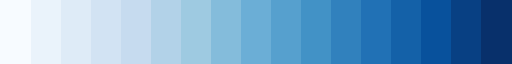

In [20]:
from matplotlib.cm import get_cmap
get_cmap('Blues',N_shots)

In [21]:
# DataFrame with inferred slice timing
# ====================================
slice_timing_pd               = pd.DataFrame(columns=['Slice Number','Shot','Slice Time'],index=np.arange(N_slices) )
shots                         = [list(np.repeat(s,MB_factor)) for s in np.arange(N_shots)]
shots                         = [item for sublist in shots for item in sublist]
slice_timing_pd['Shot']       = shots
slice_timing_pd['Slice Time'] = slice_timing_pd['Shot'] * Intershot_timing

In [22]:
slice_order = []
for inc in np.arange(Increment_slice):
    for shot in np.arange(N_shots):
        slices_per_shot = np.arange(inc+Increment_slice*shot,N_slices,N_shots)
        if len(slices_per_shot) == MB_factor:
            slice_order = slice_order + list(slices_per_shot)
slice_timing_pd['Slice Number'] = slice_order

In [23]:
slice_timing_pd.to_csv(osp.join(Resources_Dir,'HCP7T_SliceTimingTable.csv'))

/data/SFIMJGC_HCP7T/Apps/envs/hcp7t_fv_sleep_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app


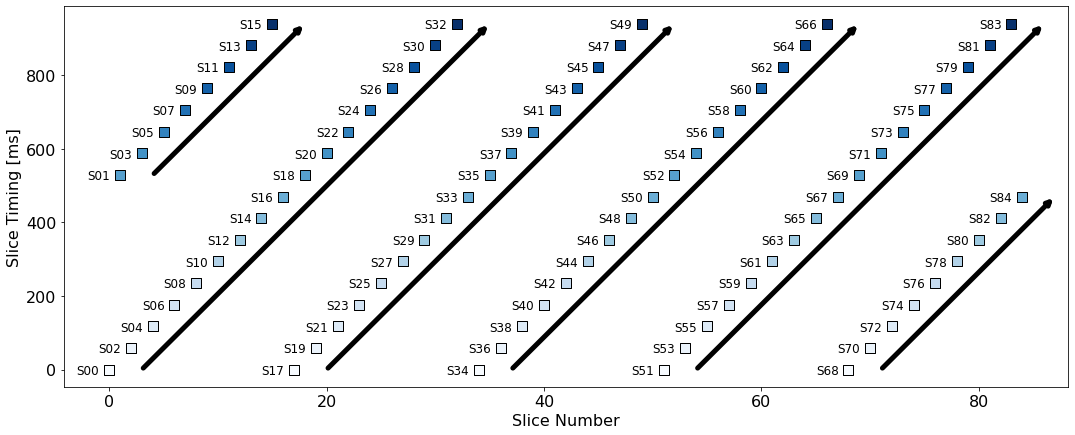

In [24]:
%matplotlib inline
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
fig, axs = plt.subplots(1,1,figsize=(18,7))
slice_timing_pd.plot.scatter(x='Slice Number',y='Slice Time', ax=axs, s=100, marker='s',color=[shot_cmap_dict[c] for c in slice_timing_pd['Shot']], edgecolor='k')
axs.set_xlabel('Slice Number', fontsize=16)
axs.set_ylabel('Slice Timing [ms]', fontsize=16)
for r,row in slice_timing_pd.iterrows():
    axs.annotate('S'+str(int(row['Slice Number'])).zfill(2),(row['Slice Number']-3,row['Slice Time']-12), fontsize=12)
for (bot_sl,top_sl) in [(1,15),(0,32),(17,49),(34,66),(51,83),(68,84)]:
    x0 = bot_sl
    x1 = top_sl
    y0 = slice_timing_pd[slice_timing_pd['Slice Number']==bot_sl]['Slice Time'].values[0]
    y1 = slice_timing_pd[slice_timing_pd['Slice Number']==top_sl]['Slice Time'].values[0]
    plt.annotate(s='', xy=(x1+3,y1), xytext=(x0+3,y0), arrowprops=dict(facecolor='black', lw=5, arrowstyle='->'))#dict(arrowstyle='->',width=3));
#axs.arrow(1+1,  slice_timing_pd[slice_timing_pd['Slice Number']==1]['Slice Time'].values[0],
#          15+1, slice_timing_pd[slice_timing_pd['Slice Number']==15]['Slice Time'].values[0]-slice_timing_pd[slice_timing_pd['Slice Number']==1]['Slice Time'].values[0],width=1)

***
# Slice Profiles (95th to 5th Percentile Ratio)

In [ ]:
per_slice_TS       = xr.DataArray(dims=['Segment','Slice','Time'], coords={'Segment':segment_list,'Slice':np.arange(0,85),'Time':np.arange(0,890)})
per_slice_Qratio   = pd.DataFrame(index=np.arange(0,85), columns=segment_list)
for s,s_row in ec_segments.iterrows():
    aux_onset  = int(s_row['Onset'])
    aux_offset = int(s_row['Offset'])
    aux_segID  = s_row['Segment_UUID']
    aux_scanID = s_row.name
    aux_sbj, aux_run = aux_scanID.split('_',1)
    path       = osp.join(DATA_DIR,aux_sbj,aux_run,'{run}_orig.detrend.FV.k.csv'.format(run=aux_run))
    aux        = pd.read_csv(path, sep='\t')
    aux        = aux.drop(['File','Sub-brick'], axis=1)
    aux.index.name = 'Time'
    aux.columns    = [int(c.split('_',1)[1]) for c in aux.columns ]
    aux            = aux.loc[aux_onset:aux_offset]
    per_slice_TS.loc[aux_segID,aux.columns,aux.index] = aux.T
    per_slice_Qratio.loc[:,aux_segID] = aux.quantile(0.95,axis=0) / aux.quantile(0.05,axis=0)

NameError: name 'xr' is not defined

* Load Median Locations of the Dorsomedial Recess and the Obex across the 26 scans that we are considering for this part of the analyses

In [27]:
structs_info  = pd.read_csv(osp.join(DATA_DIR,'ALL','ALL_orig.struc_info.csv'),index_col=[0,1])
structs_lines = structs_info.unstack().median()
structs_lines
dmr_location  = int(structs_lines[0])
obex_location = int(structs_lines[1])
print("++ INFO: Obex Location:               %f"%  obex_location)
print("++ INFO: Dorsomedial Recess Location: %f"%  dmr_location)

++ INFO: Obex Location:               11.000000
++ INFO: Dorsomedial Recess Location: 23.000000


* Load Slice Timing and Shot information for coloring purposes

In [28]:
slice_timing_pd = pd.read_csv(osp.join(Resources_Dir,'HCP7T_SliceTimingTable.csv'), index_col=0)
slice_timing_pd = slice_timing_pd.sort_values(by='Slice Number').set_index('Slice Number', drop=True)

* Compute averate ratio values across all segments

In [29]:
aux_mean = per_slice_Qratio.mean(axis=1)
aux_stdv = per_slice_Qratio.std(axis=1)
aux_ster = aux_stdv / np.sqrt(per_slice_Qratio.shape[1])
per_slice_Qratio_STATS = pd.concat([aux_mean,aux_stdv,aux_ster,slice_timing_pd['Shot']],axis=1)
per_slice_Qratio_STATS.columns    = ['Mean','Stdv','StErr','Shot']
per_slice_Qratio_STATS.index.name = 'Slice Number'

* Same Result but with Matplotlib (which allows to easily add the error bars)

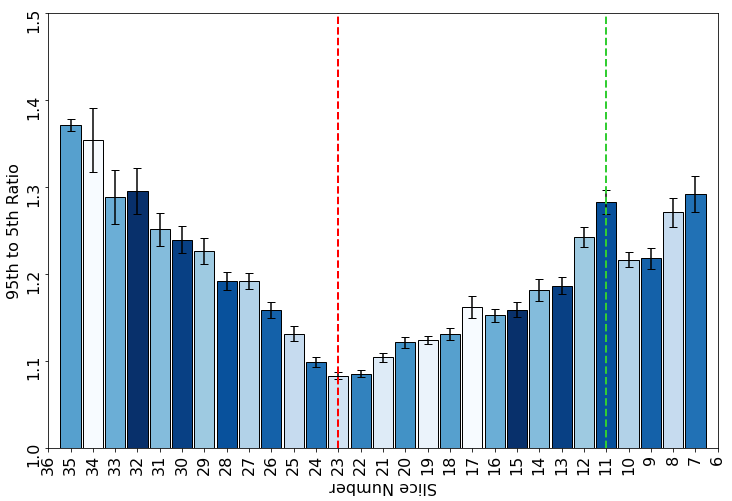

In [30]:
%matplotlib inline
import matplotlib 

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
fig,axs = plt.subplots(1,1,figsize=(12,8))
per_slice_Qratio_STATS.reset_index().plot.bar(x='Slice Number',y='Mean', 
                                                     ax=axs, width=.9 , 
                                                     color=[shot_cmap_dict[c] for c in per_slice_Qratio_STATS['Shot']],
                                                     edgecolor='k',
                                                     yerr='StErr', capsize=4)
axs.plot([obex_location,obex_location],[1,1.5],c='limegreen',lw=2,linestyle='dashed')
axs.plot([dmr_location,dmr_location],[1,1.5],c='red',lw=2,linestyle='dashed')
axs.set_ylabel('95th to 5th Ratio', fontsize=16)
axs.set_xlabel('Slice Number', fontsize=16, rotation=180)
axs.set_ylim([1,1.5])
axs.set_xlim([36,6])
axs.get_legend().remove()
plt.yticks(rotation = 90);

* Now separate graphs per inflow direction

In [31]:
inflow_directions = {0:[1,3,5,7,9,11,13,15],
                     1:[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32],
                     2:[17,19,21,23,25,27,29,31,33,35,37]}

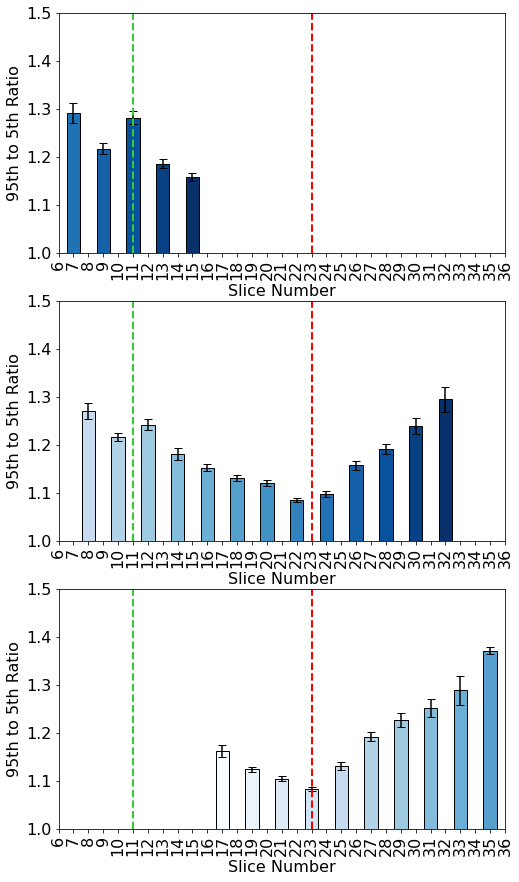

In [32]:
fig,axs = plt.subplots(3,1,figsize=(8,15))
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

for inflow_dir in [0,1,2]:
    aux = per_slice_Qratio_STATS.copy().reset_index()
    for i in np.arange(85):
        if not(i in inflow_directions[inflow_dir]):
            aux.loc[i,'Mean']  = np.NaN
            aux.loc[i,'Stdv']  = np.NaN
            aux.loc[i,'StErr'] = np.NaN
    # Plot
    aux.plot.bar(x='Slice Number',y='Mean', ax=axs[inflow_dir], width=.9 , 
                 color=[shot_cmap_dict[c] for c in aux['Shot']],
                 edgecolor='k',yerr='StErr', capsize=4)
    axs[inflow_dir].plot([obex_location,obex_location],[1,1.5],c='limegreen',lw=2,linestyle='dashed')
    axs[inflow_dir].plot([dmr_location,dmr_location],[1,1.5],c='red',lw=2,linestyle='dashed')
    axs[inflow_dir].set_ylabel('95th to 5th Ratio', fontsize=16)
    axs[inflow_dir].set_xlabel('Slice Number', fontsize=16)
    axs[inflow_dir].get_legend().remove()
    axs[inflow_dir].set_ylim([1,1.5])
    axs[inflow_dir].set_xlim([6,36])

In [51]:
selected_subjects_list = list(set([item.split('_',1)[0] for item in selected_scans_list]))

['131217',
 '581450',
 '782561',
 '958976',
 '943862',
 '251833',
 '899885',
 '132118',
 '115825',
 '185442',
 '905147',
 '771354',
 '187345',
 '176542',
 '118225',
 '365343',
 '146129',
 '966975',
 '104416',
 '169040']

* Plot Ratio Values across consecutive slices

***
# Slice Profile (based on PSD sleep)

In [33]:
from utils.basics import generate_sleep_psd
WIN_LENGTH, WIN_OVERLAP, NFFT, SCALING, DETREND, FS  = 60, 59, 128, 'density', 'constant', 1

In [34]:
%%time
per_slice_PSDsleep = pd.DataFrame(index=np.arange(0,85), columns=segment_list)
for s,(_,s_row) in enumerate(ec_segments.iterrows()):
    aux_segID  = s_row['Segment_UUID']
    aux_scanID = s_row.name
    sbj,run    = aux_scanID.split('_',1)
    onset      = int(s_row['Onset'])
    offset     = int(s_row['Offset']) 
    
    path        = osp.join(DATA_DIR,sbj,run,'{RUN}_orig.detrend.FV.k.csv'.format(RUN=run))
    aux         = pd.read_csv(path, sep='\t').drop(['File','Sub-brick'],axis=1)
    aux.columns = [int(c.split('_',1)[1]) for c in aux.columns ]
    
    for slice_id in aux.columns:
        ts = aux[slice_id]
        # Compute Spectrogram
        f,t,Sxx        = spectrogram(ts,FS,window=get_window(('tukey',0.25),WIN_LENGTH), noverlap=WIN_OVERLAP, scaling=SCALING, nfft=NFFT, detrend=DETREND, mode='psd')
        # Compute Average Power/Time in Sleep Band
        band_lim_spect_df = generate_sleep_psd(f,t,Sxx)
        # Save mean PSDsleep into summary dataframe
        per_slice_PSDsleep.loc[slice_id,aux_segID] = band_lim_spect_df.loc[onset:offset,'sleep'].mean()

CPU times: user 24.7 s, sys: 222 ms, total: 24.9 s
Wall time: 25 s


In [35]:
aux_mean = per_slice_PSDsleep.mean(axis=1)
aux_stdv = per_slice_PSDsleep.std(axis=1)
aux_ster = aux_stdv / np.sqrt(per_slice_PSDsleep.shape[1])
per_slice_PSDsleep_STATS = pd.concat([aux_mean,aux_stdv,aux_ster,slice_timing_pd['Shot']],axis=1)
per_slice_PSDsleep_STATS.columns    = ['Mean','Stdv','StErr','Shot']
per_slice_PSDsleep_STATS.index.name = 'Slice Number'

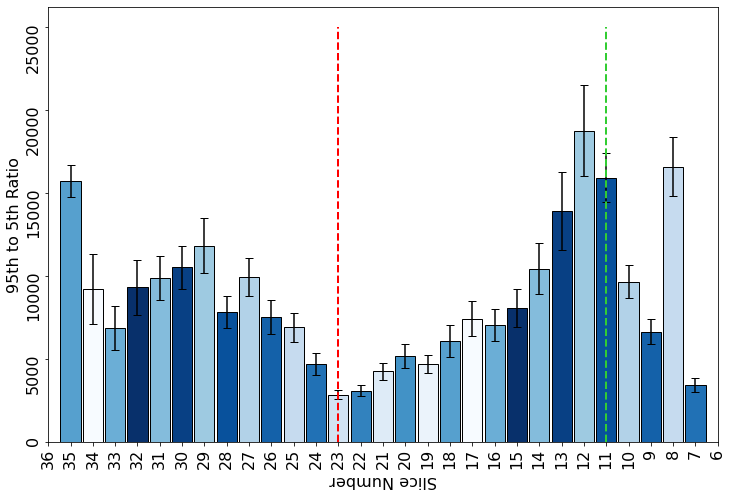

In [37]:
%matplotlib inline
import matplotlib 

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
fig,axs = plt.subplots(1,1,figsize=(12,8))
per_slice_PSDsleep_STATS.reset_index().plot.bar(x='Slice Number',y='Mean', 
                                                     ax=axs, width=.9 , 
                                                     color=[shot_cmap_dict[c] for c in per_slice_PSDsleep_STATS['Shot']],
                                                     edgecolor='k',
                                                     yerr='StErr', capsize=4)
axs.plot([obex_location,obex_location],[0,25000],c='limegreen',lw=2,linestyle='dashed')
axs.plot([dmr_location,dmr_location],[0,25000],c='red',lw=2,linestyle='dashed')
axs.set_ylabel('95th to 5th Ratio', fontsize=16)
axs.set_xlabel('Slice Number', fontsize=16, rotation=180)
axs.set_xlim([36,6])
axs.get_legend().remove()
plt.yticks(rotation = 90);

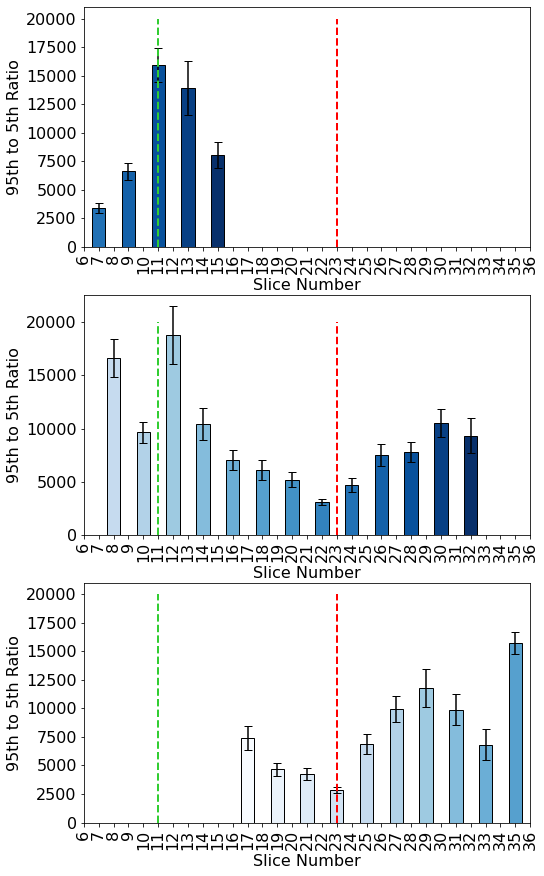

In [38]:
fig,axs = plt.subplots(3,1,figsize=(8,15))
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

for inflow_dir in [0,1,2]:
    aux = per_slice_PSDsleep_STATS.copy().reset_index()
    for i in np.arange(85):
        if not(i in inflow_directions[inflow_dir]):
            aux.loc[i,'Mean']  = np.NaN
            aux.loc[i,'Stdv']  = np.NaN
            aux.loc[i,'StErr'] = np.NaN
    # Plot
    aux.plot.bar(x='Slice Number',y='Mean', ax=axs[inflow_dir], width=.9 , 
                 color=[shot_cmap_dict[c] for c in aux['Shot']],
                 edgecolor='k',yerr='StErr', capsize=4)
    axs[inflow_dir].plot([obex_location,obex_location],[0,20000],c='limegreen',lw=2,linestyle='dashed')
    axs[inflow_dir].plot([dmr_location,dmr_location],[0,20000],c='red',lw=2,linestyle='dashed')
    axs[inflow_dir].set_ylabel('95th to 5th Ratio', fontsize=16)
    axs[inflow_dir].set_xlabel('Slice Number', fontsize=16)
    axs[inflow_dir].get_legend().remove()
    axs[inflow_dir].set_xlim([6,36])